In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle

from sksurv.ensemble import RandomSurvivalForest
from sksurv.nonparametric import kaplan_meier_estimator

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
sns.set()

Toy model to use for building out other functionality (cash flow projects, monte carlo simulation, etc.).

In [2]:
X_file = '../../Data/X_train.csv'
y_file = '../../Data/y_train.csv'

X = pd.read_csv(X_file, compression='gzip', index_col=0).reset_index(drop=True)
y = pd.read_csv(y_file, compression='gzip', index_col=0).reset_index(drop=True)

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146853 entries, 0 to 2146852
Columns: 130 entries, id to application_type_Joint App
dtypes: float64(14), int64(113), object(3)
memory usage: 2.1+ GB


In [4]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146853 entries, 0 to 2146852
Data columns (total 4 columns):
 #   Column         Dtype
---  ------         -----
 0   id             int64
 1   default        bool 
 2   prepaid        bool 
 3   survival_time  int64
dtypes: bool(2), int64(2)
memory usage: 36.9 MB


In [5]:
# use a sample of the data set to build the toy model
n_records = 50000
index_vals = X.loc[X['term'] == 36].index[:n_records]
feature_cols = [col for col in X.columns if col.startswith('grade_')]

X = X.loc[index_vals, feature_cols].copy()
y = y.loc[index_vals, :].copy()

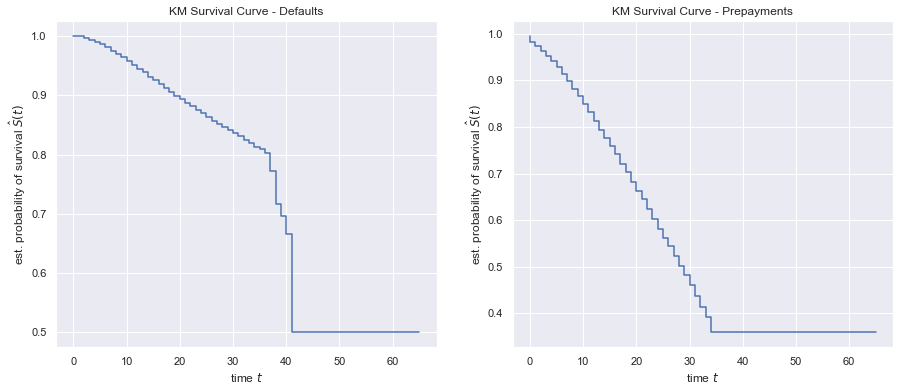

In [6]:
# plot the KM survival curves for the sample data
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

time, default_surv = kaplan_meier_estimator(y['default'], y['survival_time'])
ax[0].step(time, default_surv)
ax[0].set_title('KM Survival Curve - Defaults')
ax[0].set_ylabel("est. probability of survival $\hat{S}(t)$")
ax[0].set_xlabel("time $t$")

time, prepaid_surv = kaplan_meier_estimator(y['prepaid'], y['survival_time'])
ax[1].step(time, prepaid_surv)
ax[1].set_title('KM Survival Curve - Prepayments')
ax[1].set_ylabel("est. probability of survival $\hat{S}(t)$")
ax[1].set_xlabel("time $t$")

plt.show()

The large tails on the curves after 36 months are due to the loans that run past 36 months, but that don't default (e.g., loans with late payments).

In [7]:
y['survival_time'].describe()

count    50000.000000
mean        19.471120
std         11.301434
min          0.000000
25%         10.000000
50%         18.000000
75%         30.000000
max         65.000000
Name: survival_time, dtype: float64

In [8]:
def get_y(df, status_col, time_col):
    t = df.loc[:, time_col].to_list()
    s = df.loc[:, status_col].to_list()
    
    return np.array(list(zip(s, t)), dtype='bool, f8')

In [9]:
rsf_default = RandomSurvivalForest(n_estimators=1000,
                                   min_samples_split=10,
                                   min_samples_leaf=15,
                                   max_features='sqrt',
                                   n_jobs=-1,
                                   random_state=1234)

default_y = get_y(y, 'default', 'survival_time')
rsf_default.fit(X, default_y)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=1234)

In [10]:
rsf_prepaid = RandomSurvivalForest(n_estimators=1000,
                                   min_samples_split=10,
                                   min_samples_leaf=15,
                                   max_features='sqrt',
                                   n_jobs=-1,
                                   random_state=1234)

prepaid_y = get_y(y, 'prepaid', 'survival_time')
rsf_prepaid.fit(X, prepaid_y)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=1234)

In [11]:
surv_pred_default = rsf_default.predict_survival_function(X, return_array=True)
surv_pred_default = surv_pred_default.mean(axis=0)

surv_pred_prepaid = rsf_prepaid.predict_survival_function(X, return_array=True)
surv_pred_prepaid = surv_pred_prepaid.mean(axis=0)

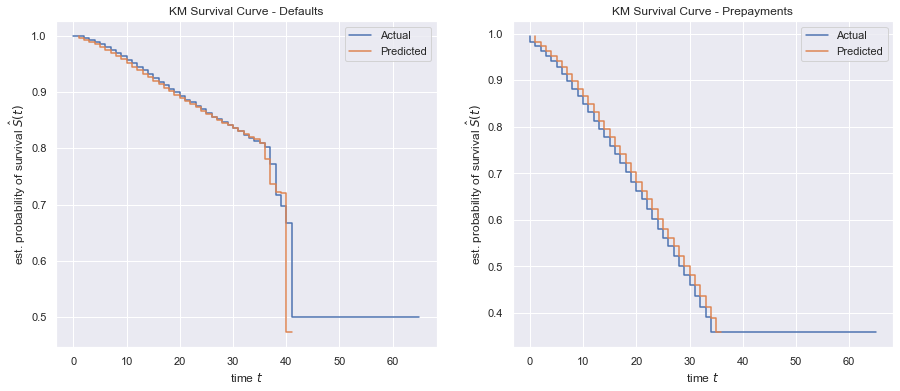

In [12]:
# plot the predicted survival curves next to the KM survival curves 
# for the sample data
# don't really care about performance here - just want to make sure 
# we have a "reasonable" model
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

time, default_surv = kaplan_meier_estimator(y['default'], y['survival_time'])
ax[0].step(time, default_surv, label='Actual')

ax[0].step(list(range(1, len(surv_pred_default) + 1)), surv_pred_default, 
           label='Predicted')

ax[0].set_title('KM Survival Curve - Defaults')
ax[0].set_ylabel("est. probability of survival $\hat{S}(t)$")
ax[0].set_xlabel("time $t$")
ax[0].legend(loc='best')

time, prepaid_surv = kaplan_meier_estimator(y['prepaid'], y['survival_time'])
ax[1].step(time, prepaid_surv, label='Actual')

ax[1].step(list(range(1, len(surv_pred_prepaid) + 1)), surv_pred_prepaid, 
           label='Predicted')

ax[1].set_title('KM Survival Curve - Prepayments')
ax[1].set_ylabel("est. probability of survival $\hat{S}(t)$")
ax[1].set_xlabel("time $t$")
ax[1].legend(loc='best')

plt.show()

As expected, the models work well on the same data set that they were trained on. Save the models since they output valid survival curves.

In [13]:
# save the two models
with open('default_model.pkl', 'wb') as f:
    pickle.dump(rsf_default, f)    
    
with open('prepayment_model.pkl', 'wb') as f:
    pickle.dump(rsf_prepaid, f)  